Original Dataset:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             norm

C:\Users\Galaxyz\AppData\Local\Temp\ipykernel_4320\3520343277.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mean_imputation[numeric_cols].fillna(df_mean_imputation[numeric_cols].mean(), inplace=True)
C:\Users\Galaxyz\AppData\Local\Temp\ipykernel_4320\3520343277.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_median_imputation[numeric_cols].fillna(df_median_imputation[numeric_cols].median(), inplace=True)
C:\Users\Galaxyz\AppData\Local\Temp\ipykernel_4320\3520343277.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
T

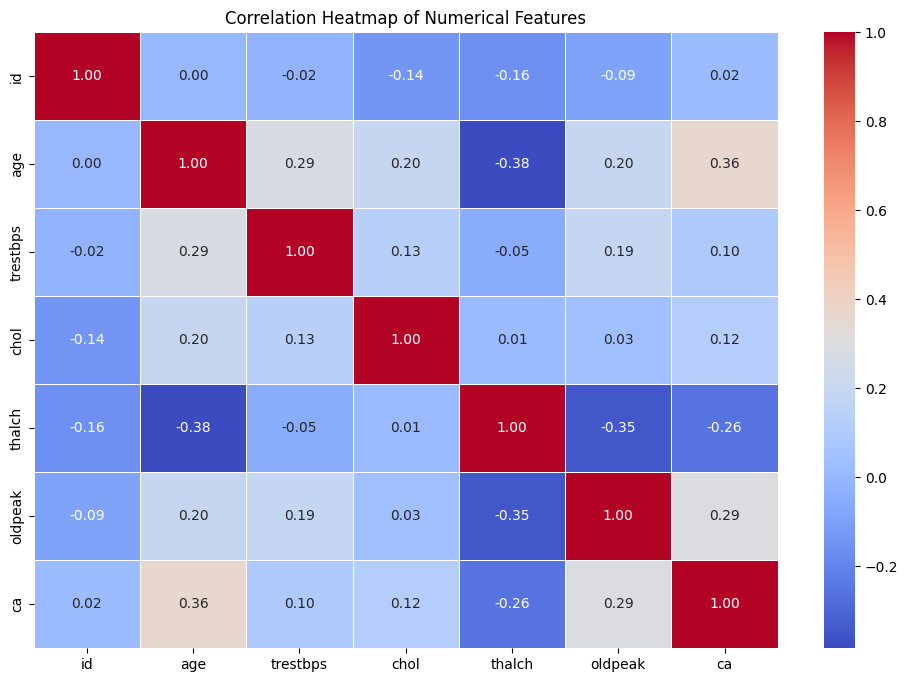


Selected Features based on Correlation Matrix (threshold > 0.1):
{'oldpeak', 'ca', 'chol', 'trestbps', 'thalch'}

Final Selected Features based on both Chi-Square and Correlation Matrix:
{'oldpeak', 'exang', 'ca', 'chol', 'fbs', 'thal', 'dataset', 'trestbps', 'thalch', 'sex', 'cp', 'restecg', 'slope'}

Dataset after Z-Score Outlier Removal: (288, 15)
Dataset after IQR Outlier Removal: (262, 15)

First 5 rows of Normalized Data:
[[0.    0.708 0.481 0.287 0.603 0.371 0.   ]
 [0.001 0.792 0.623 0.401 0.282 0.242 1.   ]
 [0.003 0.792 0.245 0.278 0.443 0.419 0.667]
 [0.004 0.167 0.34  0.323 0.885 0.565 0.   ]
 [0.005 0.25  0.34  0.224 0.771 0.226 0.   ]]

First 5 rows of Standardized Data:
[[-1.597  0.94   0.75  -0.263  0.029  1.069 -0.718]
 [-1.586  1.384  1.596  0.748 -1.79   0.38   2.487]
 [-1.576  1.384 -0.661 -0.339 -0.881  1.328  1.419]
 [-1.565 -1.944 -0.097  0.061  1.632  2.103 -0.718]
 [-1.555 -1.5   -0.097 -0.816  0.982  0.294 -0.718]]


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats

# Step 1: Load the heart disease dataset
df = pd.read_csv('heart_disease_uci.csv')

# Step 2: Display the first few rows and check for missing values
print("Original Dataset:")
print(df.head())

print("\nSummary of Missing Values in the Dataset:")
print(df.isnull().sum())

# Step 3: Handling missing data using different imputation methods

# Mean Imputation (for numeric columns)
df_mean_imputation = df.copy()
numeric_cols = df_mean_imputation.select_dtypes(include=['number']).columns
df_mean_imputation[numeric_cols].fillna(df_mean_imputation[numeric_cols].mean(), inplace=True)

print("\nDataset after Mean Imputation:")
print(df_mean_imputation.isnull().sum())

# Median Imputation (for numeric columns)
df_median_imputation = df.copy()
df_median_imputation[numeric_cols].fillna(df_median_imputation[numeric_cols].median(), inplace=True)

print("\nDataset after Median Imputation:")
print(df_median_imputation.isnull().sum())

# Mode Imputation (for categorical columns)
df_mode_imputation = df.copy()
categorical_cols = df_mode_imputation.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_mode_imputation[col].fillna(df_mode_imputation[col].mode()[0], inplace=True)

print("\nDataset after Mode Imputation:")
print(df_mode_imputation.isnull().sum())

# Forward Fill (Fill missing values with the last known value)
df_ffill = df.copy()
df_ffill.fillna(method='ffill', inplace=True)

print("\nDataset after Forward Fill:")
print(df_ffill.isnull().sum())

# Backward Fill (Fill missing values with the next known value)
df_bfill = df.copy()
df_bfill.fillna(method='bfill', inplace=True)

print("\nDataset after Backward Fill:")
print(df_bfill.isnull().sum())

# Step 5: Dropping rows with missing data (if imputation isn't preferred)
df_dropped = df.copy()
df_dropped.dropna(inplace=True)

print("\nDataset after Dropping Rows with Missing Values:")
print(df_dropped.isnull().sum())

# Step 6: Define X (features) and y (target variable)
X = df_dropped.drop(columns=['num'])  # Replace 'num' with the actual target column
y = df_dropped['num']

# Label encode the categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_categorical = X[categorical_cols]

labelencoder = LabelEncoder()
X_categorical_encoded = X_categorical.apply(labelencoder.fit_transform)

# Step 7: Apply Chi-Square test to select top k features
chi2_selector = SelectKBest(chi2, k='all').fit(X_categorical_encoded, y)
chi2_scores = chi2_selector.scores_

# Get selected features from Chi-Square
selected_features_chi2_mask = chi2_selector.get_support()
selected_features_chi2 = X_categorical.columns[selected_features_chi2_mask]

print("Chi-Square Scores for Features:")
print(chi2_scores)
print("\nSelected Features based on Chi-Square Test:")
print(selected_features_chi2)

# Step 8: Feature selection based on Correlation Matrix (for numerical features)
numeric_cols = X.select_dtypes(include=['number']).columns

# Calculate correlation matrix
correlation_matrix = X[numeric_cols].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Set a threshold for high correlation (e.g., absolute value > 0.75)
correlation_threshold = 0.1

# Find highly correlated features
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(correlation_matrix.columns[i])

print("\nSelected Features based on Correlation Matrix (threshold > 0.1):")
print(correlated_features)

# Step 9: Combine selected features from both Chi-Square and Correlation methods
selected_features_combined = set(selected_features_chi2).union(correlated_features)

print("\nFinal Selected Features based on both Chi-Square and Correlation Matrix:")
print(selected_features_combined)

# Step 10: Outlier Detection

# Detect outliers using Z-score on numeric data only
X_numeric = X.select_dtypes(include=[np.number])
z_scores = np.abs(stats.zscore(X_numeric))
X_zscore = X[(z_scores < 3).all(axis=1)]
y_zscore = y[(z_scores < 3).all(axis=1)]

print(f"\nDataset after Z-Score Outlier Removal: {X_zscore.shape}")

# Detect outliers using IQR
Q1 = X_numeric.quantile(0.25)
Q3 = X_numeric.quantile(0.75)
IQR = Q3 - Q1
X_iqr = X[~((X_numeric < (Q1 - 1.5 * IQR)) | (X_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]
y_iqr = y[~((X_numeric < (Q1 - 1.5 * IQR)) | (X_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Dataset after IQR Outlier Removal: {X_iqr.shape}")

# Step 11: Feature Scaling

# Feature scaling (Normalization and Standardization)
scaler_norm = MinMaxScaler()
scaler_std = StandardScaler()

# Apply scaling to the numeric data
X_normalized = scaler_norm.fit_transform(X_numeric)
X_standardized = scaler_std.fit_transform(X_numeric)

# Display first 5 rows of normalized and standardized data
print("\nFirst 5 rows of Normalized Data:")
print(np.round(X_normalized[:5], 3))

print("\nFirst 5 rows of Standardized Data:")
print(np.round(X_standardized[:5], 3))
